# 实施主要包含以下几个步骤:

* 数据预处理
* 导出特征向量（不需要重复计算）
* 载入特征向量
* 构建模型
* 训练模型
* 预测结果

## 步骤一：数据预处理

In [2]:
import os
import shutil
os.chdir("{}/image".format(os.getcwd())) 
train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')

rmrf_mkdir('test2')
os.symlink('../test/', 'test2/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'train2/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'train2/dog/'+filename)
os.chdir("..")     

结构如下：

```
├── image
│   ├── img_test
│   │   └── test
│   ├── img_train
│   │   ├── cat
│   │   └── dog
│   ├── img_valid
│   │   ├── cat
│   │   └── dog
│   ├── test
│   ├── test2
│   │   └── test -> ../test/
│   ├── train
│   ├── train2
│   │   ├── cat
│   │   └── dog
```

## 步骤二：导出特征向量

In [3]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint, TensorBoard

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("image/train2", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("image/test2", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

/home/calvin.zhang/miniconda3/envs/dlnd-tf-lab-new/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# write_gap(ResNet50, (224, 224))
# write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
# write_gap(Xception, (299, 299), xception.preprocess_input)

# write_gap(VGG16, (299, 299))
# write_gap(VGG19, (299, 299))

## 步骤三：载入特征向量

In [5]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2018)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_InceptionV3.h5","gap_VGG16.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)
print(len(X_test),len(X_train))

X_train, y_train = shuffle(X_train, y_train)

12500 25000


## 步骤四：搭建模型

In [6]:
from keras.models import *
from keras.layers import *

np.random.seed(4)

input_tensor = Input(X_train.shape[1:])

x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

model = Model(input=input_tensor, output=x)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

/home/calvin.zhang/miniconda3/envs/dlnd-tf-lab-new/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## 步骤四：训练模型

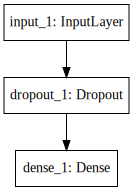

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
# hist = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2)
hist = model.fit(X_train, y_train, batch_size=128, nb_epoch=40, validation_split=0.2, callbacks=[TensorBoard(log_dir='union_tensorlog')])

/home/calvin.zhang/miniconda3/envs/dlnd-tf-lab-new/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 20000 samples, validate on 5000 samples
Epoch 1/40
20000/20000 [==============================] - 1s 38us/step - loss: 0.1015 - acc: 0.9614 - val_loss: 0.0289 - val_acc: 0.9898
Epoch 2/40
20000/20000 [==============================] - 1s 25us/step - loss: 0.0348 - acc: 0.9879 - val_loss: 0.0247 - val_acc: 0.9910
Epoch 3/40
20000/20000 [==============================] - 1s 27us/step - loss: 0.0291 - acc: 0.9896 - val_loss: 0.0244 - val_acc: 0.9918
Epoch 4/40
20000/20000 [==============================] - 0s 24us/step - loss: 0.0238 - acc: 0.9913 - val_loss: 0.0237 - val_acc: 0.9920
Epoch 5/40
20000/20000 [==============================] - 0s 23us/step - loss: 0.0195 - acc: 0.9934 - val_loss: 0.0262 - val_acc: 0.9906
Epoch 6/40
20000/20000 [==============================] - 1s 26us/step - loss: 0.0198 - acc: 0.9930 - val_loss: 0.0240 - val_acc: 0.9914
Epoch 7/40
20000/20000 [==============================] - 1s 30us/step - loss: 0.0184 - acc: 0.9932 - val_loss: 0.0244 - val_acc:

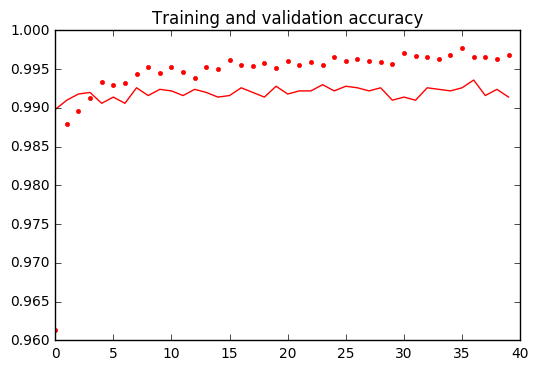

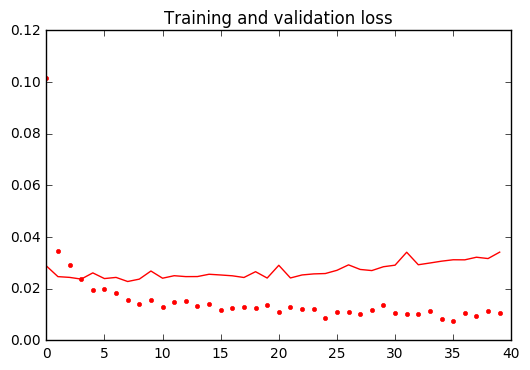

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# 画图
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()

# 训练的acc_loss图
plot_training(hist)

## 预测结果

In [10]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("image/test2", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('submission_union.csv', index=None)
df.head(10)

12500/12500 [==============================] - 0s 28us/step
Found 12500 images belonging to 1 classes.


/home/calvin.zhang/miniconda3/envs/dlnd-tf-lab-new/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.005
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
